# Проведение RFM-анализа (сегментирования)

# Оглавление  

1. [Введение](#1.-Введение)
2. [Загрузка библиотек и датасета](#2.-Загрузка-библиотек-и-датасета)    
    2.1 [Загрузка библиотек](#2.1-Загрузка-библиотек)  
    2.2 [Загрузка датасета](#2.2-Загрузка-датасета)
3. [Описание датасета](#3.-Описание-датасета)
4. [Подготовка данных](#4.-Подготовка-данных)  
    4.1 [Ключевые признаки для RFM-анализа](#4.1-Ключевые-признаки-для-RFM-анализа)  
    4.2 [Пропущенные значения](#4.2-Пропущенные-значения)  
    4.3 [Типы признаков](#4.3-Типы-признаков)  
    4.4 [Добавление столбцы с общей суммой](#4.4-Добавление-столбцы-с-общей-суммой)    
5. [RFM-анализ](#5.-RFM-анализ)  
    5.1 [R (Recency)](#5.1-R-(Recency))  
    5.2 [F (Frequency)](#5.2-F-(Frequency))  
    5.3 [M (Monetary)](#5.3-M-(Monetary))  
    5.4 [Метки RFM для сегментации](#5.4-Метки-RFM-для-сегментации)  
    5.5 [Cегментация клиентов](#5.5-Cегментация-клиентов) 
6. [Выводы](#6.-Выводы)

# 1. Введение

**RFM-анализ** — метод сегментации. Сегменты это группы потребителей, которые, как правило, не пересекаются. 

RFM-анализ выделяет **три признака**:

- **R (Recency)** — насколько давно клиент сделал свой последний заказ.
- **F (Frequency)** — частота заказов клиента.
- **M (Monetary)** — общая сумма заказа каждого клиента.

По данным признакам будем присваивать **степени 1, 2, 3**, где 1 - высокий уровень, далее по нисходящей. 

Что можем получить:

- **Идентифицировать покупателей, который покупают часто и последний заказ был недавно**. Это ключевые покупатели. Таких клиентов полезно узучить, провести с ними опросы, узнать чем их конкретно привлекает данный сервис и/или товар, установить партнерские отношения. Также можно устроить спецакцию, при этом не обязательно это будет скидка на товар, это может быть, например, приглашение на мероприятие компании или же проведение совместной взаимовыгодной рекламной кампании. 
- **Идентифицировать покупателей, которые покупают часто, но либо мало, либо с маленьким средним чеком**. С такими клиентами работа будет заключаться в анализе причин покупок на небольшие суммы (вполне возможно, что они не знают о каких-то товарах), а далее нужно постараться поднять их средний чек.
- **Идентифицировать покупателей, которые раньше покупали часто и много, но по какой-то причине перестали покупать**. Необходимо проанализировать причины их ухода и попытаться вернуть их на сервис. 


# 2. Загрузка библиотек и датасета

## 2.1 Загрузка библиотек

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import datetime
from dateutil.relativedelta import relativedelta

from kaggle.api.kaggle_api_extended import KaggleApi

import warnings
warnings.filterwarnings("ignore")

## 2.2 Загрузка датасета

In [3]:
!kaggle datasets list -s 'e-commerce'

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/carrie1/ecommerce-data                                 E-Commerce Data                                     7MB  2017-08-17 02:44:30          84183       1226  0.7058824        
datasets/nicapotato/womens-ecommerce-clothing-reviews           Women's E-Commerce Clothing Reviews                 3MB  2018-02-03 19:59:19          46283        921  0.88235295       
datasets/olistbr/brazilian-ecommerce                            Brazilian E-Commerce Public Dataset by Olist       43MB  2021-10-01 19:08:27         122215       2218  1.0              
datasets/prachi13/customer-analytics                             E-Com

In [4]:
api = KaggleApi()
api.authenticate()
api.dataset_download_files("carrie1/ecommerce-data", path='C:\\Users\\ЯцкийНА\\Portfolio\\RFM_Segmentation\\Data', unzip=True)

In [5]:
df = pd.read_csv('Data\\data.csv', encoding='ISO-8859-1')

# 3. Описание датасета

"Обычно наборы данных электронной коммерции являются закрытыми, и поэтому их трудно найти среди общедоступных данных. Однако репозиторий машинного обучения UCI создал этот набор данных, содержащий фактические транзакции за 2010 и 2011 годы. Набор данных поддерживается на их сайте, где его можно найти по заголовку «Розничная торговля в Интернете.

Это транснациональный набор данных, который содержит все транзакции, имевшие место между 12.01.2010 и 12.09.2011 для зарегистрированной в Британии розничной онлайн-торговли. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками" - описание с Kaggle 

В датасете содержится 541909 строк и 8 столбцов.

На Kaggle не было описание признаков, предположим:

- **InvoiceNo**: Номер счета. Номер содержит 6 знаков, присваивается каждой транзакции. Если код начинается с буквы "С", это указывает на отмену или возврат, при этом в графе Quantity указывается число со знаком минус. 
- **StockCode**: Код товара. Код уникален для каждого товара.
- **Description**: Наименование товара.
- **Quantity**: Количество каждого товара в транзакции.
- **InvoiceDate**: Дата и время выставления счета.
- **UnitPrice**: Цена за единицу товара.
- **CustomerID**: Идентификационный номер покупателя. Присваивается каждому покупателю.
- **Country**: Название страны, в которой проживает покупатель.

**Ключевые признаки для RFM-анализа**:
- CustomerID
- Quantity и UnitPrice (далее сделаем рассчет в отдельной колонке по общей сумме по каждой позиции)
- InvoiceDate

In [6]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


# 4. Подготовка данных

## 4.1 Ключевые признаки для RFM-анализа

Оставим в датасете только ключевые признаки для RFM-анализа

In [7]:
rfm_df = df[['CustomerID', 'InvoiceDate', 'Quantity', 'UnitPrice']]

rfm_df.head()

,CustomerID,InvoiceDate,Quantity,UnitPrice
0,17850.0,12/1/2010 8:26,6,2.55
1,17850.0,12/1/2010 8:26,6,3.39
2,17850.0,12/1/2010 8:26,8,2.75
3,17850.0,12/1/2010 8:26,6,3.39
4,17850.0,12/1/2010 8:26,6,3.39


## 4.2 Пропущенные значения

Исследуем пропущенные значения

<AxesSubplot:>

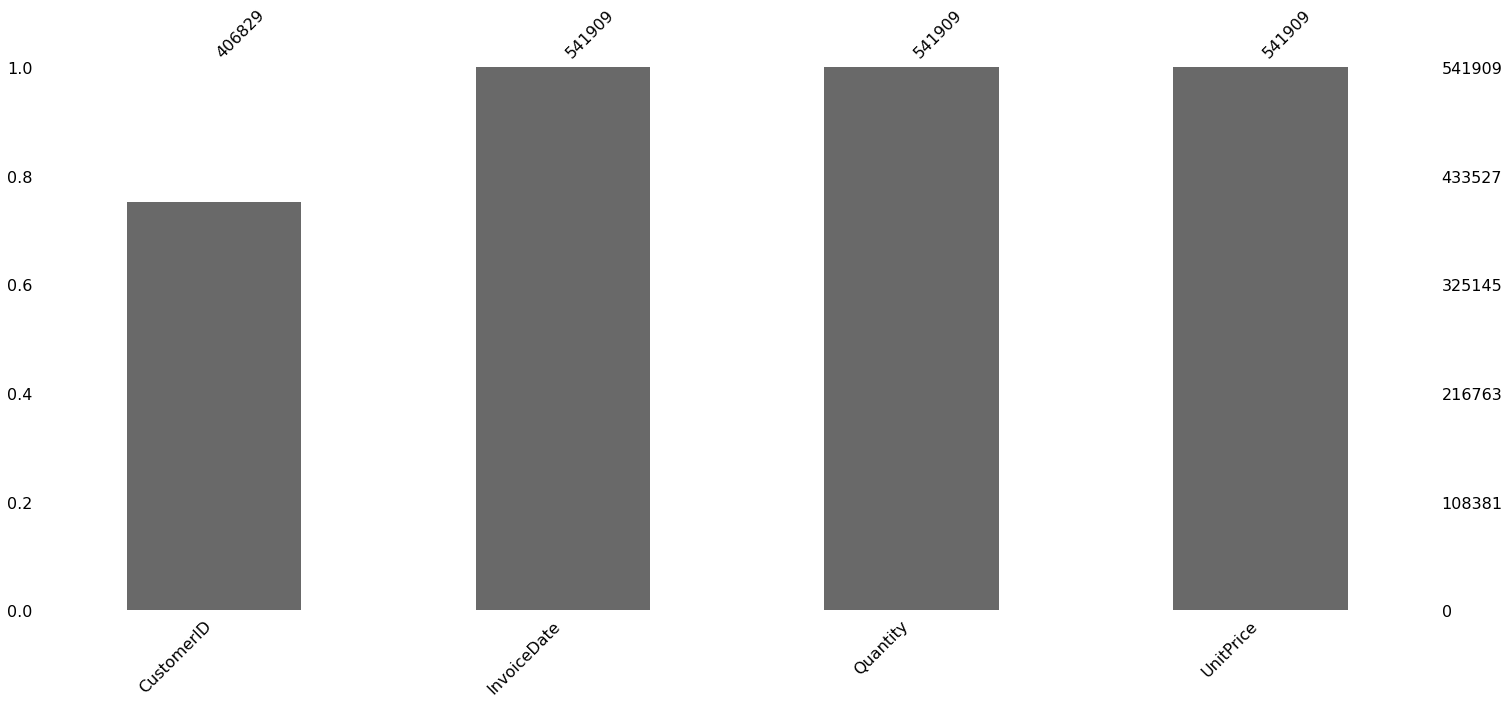

In [8]:
msno.bar(rfm_df)

<AxesSubplot:>

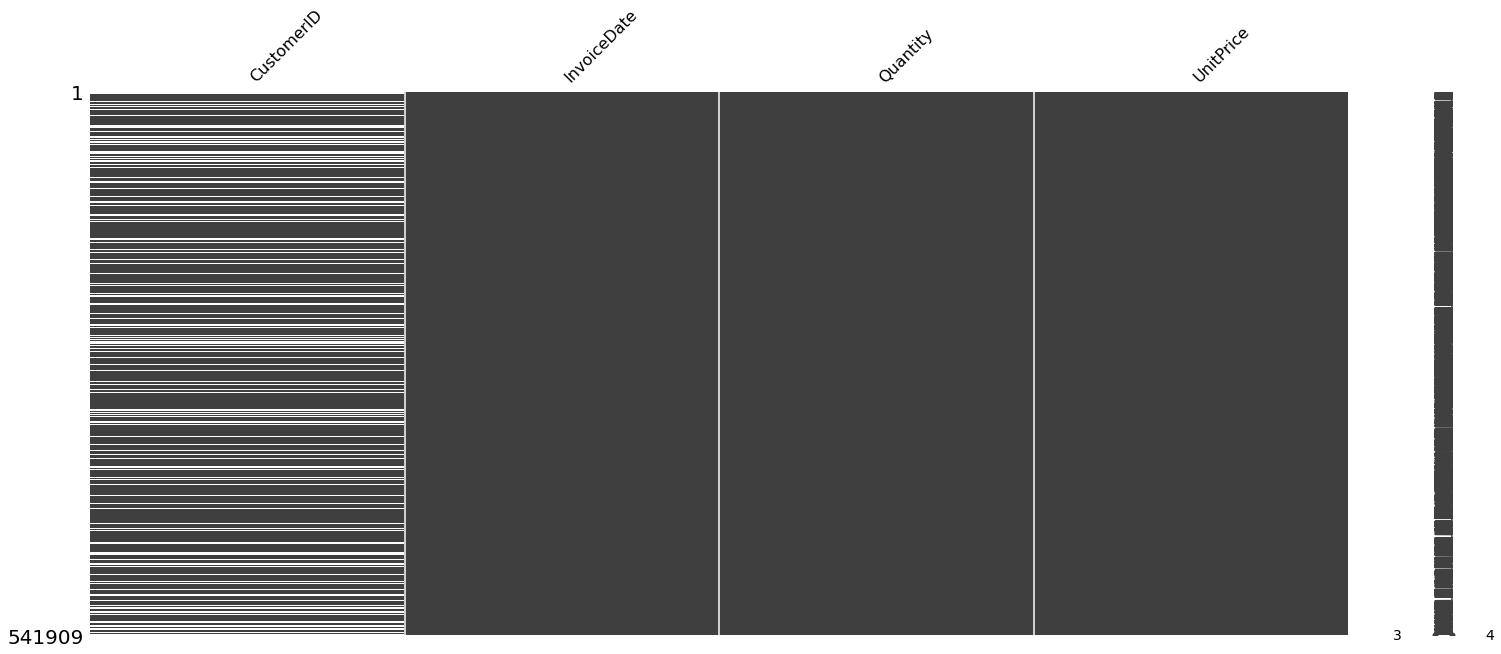

In [9]:
msno.matrix(rfm_df)

<div class="alert alert-block alert-info">
<b>Вывод:</b> Как мы можем увидеть, колосальное количество пропущенных значений в <b>CustomerID</b>, пропуски рапределены по всему датасету. 

Данный признак номинальный и является ключевым. Заполнить его случайными значениниями, или модальным значением мы не можем. Также мы не можем по другим признакам в датасете идентифицировать покупателя. Нам критически важно знать, кто явялется прокупателем, для дальнейшей работы с ним, иначе RFM-анализ становится бессмысленным. 

Данные пропуски придется отбросить.
</div>





**Отбрасываем пропущенные значения в CustomerID**

In [10]:
rfm_df.dropna(inplace = True)

## 4.3 Типы признаков

Изучим типы признаков

In [11]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CustomerID   406829 non-null  float64
 1   InvoiceDate  406829 non-null  object 
 2   Quantity     406829 non-null  int64  
 3   UnitPrice    406829 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 15.5+ MB


<div class="alert alert-block alert-info">
<b>Вывод:</b> <b>CustomerID</b> желательно поменять тип на int

<b>InvoiceDate</b> необходимо задать тип <b>datetime</b> и вытащить только дату. Так как в датасете данные были сгенерированы за 2010 и 2011 года, то для удобства можно приблизить дату к 2022 году. В любом случае это искуственные данные.

</div>

**Зададим корректные типы данных и приблизим даты к 2022 году**

In [12]:
rfm_df['CustomerID'] = rfm_df['CustomerID'].astype(int)

rfm_df['InvoiceDate'] = pd.to_datetime(rfm_df['InvoiceDate']).dt.date

#Приближаем данные к 2022 году
rfm_df['InvoiceDate'] = rfm_df['InvoiceDate']\
                        .apply(lambda x: x + relativedelta(years=(datetime.datetime.now().year - 2011 - 1)))



In [13]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CustomerID   406829 non-null  int32  
 1   InvoiceDate  406829 non-null  object 
 2   Quantity     406829 non-null  int64  
 3   UnitPrice    406829 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 14.0+ MB


## 4.4 Добавление столбцы с общей суммой

Добавим необходимый столбец с общей суммой

In [14]:
rfm_df['Sum'] = rfm_df['Quantity'] * rfm_df['UnitPrice']

rfm_df.head()

,CustomerID,InvoiceDate,Quantity,UnitPrice,Sum
0,17850,2020-12-01,6,2.55,15.30
1,17850,2020-12-01,6,3.39,20.34
2,17850,2020-12-01,8,2.75,22.00
3,17850,2020-12-01,6,3.39,20.34
4,17850,2020-12-01,6,3.39,20.34


# 5. RFM-анализ

## 5.1 R (Recency)

Рассчитаем дату последнего заказа (Last_invoice_date) и сколько времени прошло с последнего заказа до отчетной даты (Delta_date)

In [15]:
#Возьмем отчетную дату анализа 31 декабря 2021 года

current_date = datetime.date(2021,12,31)

last_date_df = rfm_df\
               .sort_values('InvoiceDate')\
               .groupby('CustomerID')['InvoiceDate']\
               .last()\
               .reset_index()\
               .rename(columns={'InvoiceDate':'Last_invoice_date'})\
               .assign(Current_date=current_date, Delta_date=lambda df: df['Current_date'] - df['Last_invoice_date'])\
               .drop(columns='Current_date')


last_date_df.head()

,CustomerID,Last_invoice_date,Delta_date
0,12346,2021-01-18,347 days
1,12347,2021-12-07,24 days
2,12348,2021-09-25,97 days
3,12349,2021-11-21,40 days
4,12350,2021-02-02,332 days


In [16]:
last_date_df['Delta_date'].describe()

count                           4372
mean     113 days 13:56:55.553522416
std      100 days 18:31:52.836716494
min                 22 days 00:00:00
25%                 38 days 00:00:00
50%                 72 days 00:00:00
75%                165 days 00:00:00
max                395 days 00:00:00
Name: Delta_date, dtype: object

<div class="alert alert-block alert-info">
<b>Вывод:</b> 50% клиентов делали последний заказ в промежутке между 72 и 395 днями назад.
</div>

## 5.2 F (Frequency)

Рассчитаем частоту заказов клиента 

In [17]:
#Функция для отрисовки распределения 
def plot(x, title):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.histplot(x=x, kde=True)
    fig.suptitle(title, fontsize=16)
    plt.show()

In [18]:
#Считаем количество покупок каждого клиента
freq = rfm_df['CustomerID'].value_counts()

freq_df = pd.DataFrame({'CustomerID':freq.index, 'Frequency':freq.values})

freq_df.head()

,CustomerID,Frequency
0,17841,7983
1,14911,5903
2,14096,5128
3,12748,4642
4,14606,2782


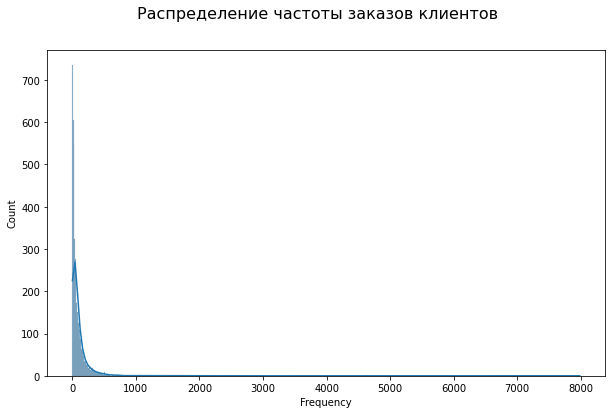

In [19]:
plot(freq_df['Frequency'], 'Распределение частоты заказов клиентов')

In [20]:
#Изучаем однородность данных

percentiles = np.append(np.linspace(0.2, 0.8, num=7), [0.9, 0.99])

freq_df['Frequency'].describe(percentiles = percentiles)


count    4372.000000
mean       93.053294
std       232.471608
min         1.000000
20%        14.000000
30%        21.000000
40%        29.000000
50%        42.000000
60%        58.000000
70%        85.000000
80%       124.000000
90%       212.000000
99%       671.870000
max      7983.000000
Name: Frequency, dtype: float64

<div class="alert alert-block alert-info">
<b>Вывод:</b> Видна огромная разница между максимальным количеством заказов покупателя и 99% другими покупателями. Вполне вероятно, что следует выделить в отдельный RFM сегмент покупателей, которые совершили от 672 до 7983 покупок. Узнаем ID таких клиентов и посчитаем их количество.
</div>

In [21]:
#Фильтруем клиентов с наибольшим количестом заказов

most_freq_df = freq_df[freq_df['Frequency']>672]

most_freq_df.head()

,CustomerID,Frequency
0,17841,7983
1,14911,5903
2,14096,5128
3,12748,4642
4,14606,2782


In [22]:
print(f'Количество покупателей с наибольшим количеством заказов - {most_freq_df.shape[0]}')

Количество покупателей с наибольшим количеством заказов - 44


In [23]:
# Можно выгрузить в Excel для дальнейшей работы

most_freq_df.to_excel('Top frequency client.xlsx')

## 5.3 M (Monetary)

Рассчитываем общую сумму заказов каждого клиента (LTV по общему доходу)

In [24]:
# Группируем по покупателю, суммируем и сортируем по убыванию

ltv_df = rfm_df\
         .groupby(by=['CustomerID'])[['Quantity', 'Sum']]\
         .sum()\
         .rename(columns={'Quantity':'Total_quantity', 'Sum':'Total_sum'})\
         .sort_values(by='Total_sum', ascending=False)\
         .reset_index()

ltv_df.head()

,CustomerID,Total_quantity,Total_sum
0,14646,196719,279489.02
1,18102,64122,256438.49
2,17450,69029,187482.17
3,14911,77180,132572.62
4,12415,77242,123725.45


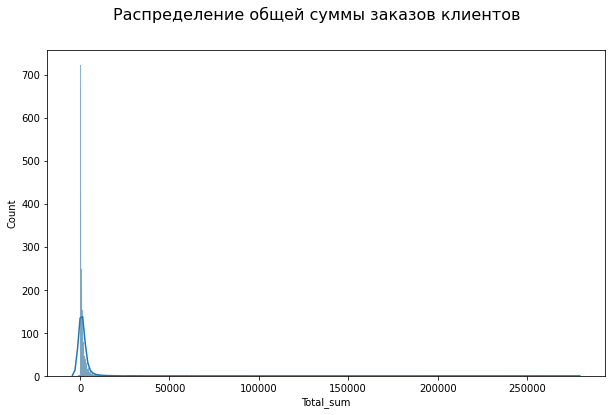

In [25]:
plot(ltv_df['Total_sum'], 'Распределение общей суммы заказов клиентов')

In [26]:
#Изучаем однородность данных

percentiles = np.append(np.linspace(0.2, 0.8, num=4), [0.9, 0.99])

ltv_df['Total_sum'].describe(percentiles = percentiles)

count      4372.000000
mean       1898.459701
std        8219.345141
min       -4287.630000
20%         234.392000
40%         465.412000
50%         648.075000
60%         909.134000
80%        2002.092000
90%        3505.600000
99%       17226.294900
max      279489.020000
Name: Total_sum, dtype: float64

<div class="alert alert-block alert-info">
<b>Вывод:</b> Так же как и с частотой видна разница между максимальной общей суммой заказов покупателя и 99% другими покупателями. Узнаем ID таких клиентов и посчитаем их количество.
</div>

In [27]:
#Фильтруем клиентов с наибольшим значением LTV

most_ltv_df = ltv_df[ltv_df['Total_sum']>17226]

most_ltv_df.head()

,CustomerID,Total_quantity,Total_sum
0,14646,196719,279489.02
1,18102,64122,256438.49
2,17450,69029,187482.17
3,14911,77180,132572.62
4,12415,77242,123725.45


In [28]:
print(f'Количество покупателей с наибольшей общей суммой заказа - {most_ltv_df.shape[0]}')

Количество покупателей с наибольшей общей суммой заказа - 44


In [29]:
# Можно выгрузить в Excel для дальнейшей работы

most_ltv_df.to_excel('Top LTV.xlsx')

## 5.4 Метки RFM для сегментации

Объединим датасеты, полученные ив пунктах 5.1 - 5.3 и расставим метки RFM для сегментации

In [30]:
#Объединяем датасеты

final_df = last_date_df.merge(freq_df, on='CustomerID').merge(ltv_df, on='CustomerID')

final_df.head()

,CustomerID,Last_invoice_date,Delta_date,Frequency,Total_quantity,Total_sum
0,12346,2021-01-18,347 days,2,0,0.00
1,12347,2021-12-07,24 days,182,2458,4310.00
2,12348,2021-09-25,97 days,31,2341,1797.24
3,12349,2021-11-21,40 days,73,631,1757.55
4,12350,2021-02-02,332 days,17,197,334.40


**Для рассчета меток степеней возьмем данные из шагов 1-3 данного раздела**.

**Степени R (Recency)** - насколько давно клиент сделал свой последний заказ:
- Степень 1 - <38 дней. Это уровень нижнего квартиля. То есть заказывали недавно.
- Степень 2 - <72 дней. Это уровень медианы.
- Степень 3 - \>72 дней. Как мы выяснили 50% покупателей делали заказы в интервале от 72 до 395 дней назад. Эти клиенты заказывали давно.


**Степени F (Frequency)** — частота заказов клиента:
- Степень 1 - \>=672 заказов. Так как у нас есть 1% клиентов, которые совершили от 672 до 7983 покупок, будем считать частым от 672 заказов.
- Степень 2 - <672 заказов. 
- Степень 3 - <124 заказов. Таких клиентов будем считать, что заказывают они не часто в сравнении с другими.


**Степени M (Monetary)** — общая сумма заказа каждого клиента:
- Степень 1 - \>=17226. 1 % клиентов закупали на суммы в интервали от 17226 до 279489 (максимум). Это самые прибыльные клиенты.
- Степень 2 - <17226.
- Степень 3 - <2002. 80% клиентов закупали на суммы ниже 2002 у.е.

In [31]:
# Создаем функцию расстановки меток F и M

def put_rfm_marks(num, comp_tuple):
    if num >= comp_tuple[0]:
        return 1
    if num < comp_tuple[1]:
        return 3
    if num < comp_tuple[0]:
        return 2

In [32]:
delta_1 = datetime.timedelta(days=72)
delta_2 = datetime.timedelta(days=38)
f_tuple, m_tuple = (672, 124), (17226, 2002)

final_df['R'] = [1 if x < delta_2 else 2 if x < delta_1 else 3 for x in final_df['Delta_date']]
final_df['F'] = final_df['Frequency'].apply(lambda x: put_rfm_marks(x, f_tuple))
final_df['M'] = final_df['Total_sum'].apply(lambda x: put_rfm_marks(x, m_tuple))

final_df

,CustomerID,Last_invoice_date,Delta_date,Frequency,Total_quantity,Total_sum,R,F,M
0,12346,2021-01-18,347 days,2,0,0.00,3,3,3
1,12347,2021-12-07,24 days,182,2458,4310.00,1,2,2
2,12348,2021-09-25,97 days,31,2341,1797.24,3,3,3
3,12349,2021-11-21,40 days,73,631,1757.55,2,3,3
4,12350,2021-02-02,332 days,17,197,334.40,3,3,3
...,...,...,...,...,...,...,...,...,...
4367,18280,2021-03-07,299 days,10,45,180.60,3,3,3
4368,18281,2021-06-12,202 days,7,54,80.82,3,3,3
4369,18282,2021-12-02,29 days,13,98,176.60,1,3,3
4370,18283,2021-12-06,25 days,756,1397,2094.88,1,1,2


## 5.5 Cегментация клиентов

**Проведем сегментацию клиентов и выгрузим в Excel для работы**

- Идентифицируем ключевых покупателей, который покупают часто и много и последний заказ был недавно. 

In [33]:
key_clients = final_df[(final_df['R']==1) & (final_df['F']==1) & (final_df['M']==1)]

key_clients.to_excel('key_clients.xlsx')

print(f'Количество ключевых клиентов - {key_clients.shape[0]}')

Количество ключевых клиентов - 14


- Идентифицируем клиентов, которые покупают часто, но либо мало, либо с маленьким средним чеком. 

In [34]:
frequent_min_sum_clients = final_df[(final_df['F']==1) & (final_df['M']==3)]

print(f'Количество клиентов, которые покупают часто, но либо мало, либо с маленьким средним чеком - '
      f'{frequent_min_sum_clients.shape[0]}')

Количество клиентов, которые покупают часто, но либо мало, либо с маленьким средним чеком - 0


<div class="alert alert-block alert-info">
<b>Вывод:</b> Как оказалось, у нас таких нет, у нас все нормальные ребята))
</div>

- Идентифицируем клиентов, которые раньше покупали часто и много, но по какой-то причине перестали покупать. 

In [35]:
old_maj_clients = final_df[(final_df['R']==3) & (final_df['F']==1) & (final_df['M']==1)]

print(f'Количество клиентов, которые раньше покупали часто и много, но по какой-то причине перестали покупать - '
      f'{old_maj_clients.shape[0]}')

Количество клиентов, которые раньше покупали часто и много, но по какой-то причине перестали покупать - 0


<div class="alert alert-block alert-info">
<b>Вывод:</b> И таких у нас тоже не оказалось. Потрясающе!
</div>

- Можем в таком случае посмотреть, есть ли у нас клиенты, которые имели средний чек и частоту покупок, но покинули наш сервис(

In [36]:
old_avg_clients = final_df[(final_df['R']==3) & (final_df['F']==2) & (final_df['M']==2)]

print(f'Количество клиентов, которые имели средний чек и частоту покупок, но покинули наш сервис - '
      f'{old_avg_clients.shape[0]}')

Количество клиентов, которые имели средний чек и частоту покупок, но покинули наш сервис - 78


# 6. Выводы

1. Хотя данные и искуственные, что-то интересное получить удалось. Например, мы выявили ключевых клиентов. Далее список таких клиентов мы можем передать менеджерам и маркетологам для дальнейшей работы.
2. Выяснили, что  у нас нет клиентов, которые раньше покупали часто и много, но по какой-то причине перестали покупать, а также выяснили, что наши клиенты не закупают на слишком маленькие суммы.
3. Зато выявили клиентов, которые имели средний чек и частоту покупок, но покинули наш сервис. Таких мы также передадим специалистам по работе с клиентами, они могут провести опрос и выяснить причины ухода.


В целом можем смотреть различные комбинации RFM-анализа в зависимости от наших целей.